# AWD-LSTM (ULMFit)

In this notebook we train an AWD-LSTM model for the proxy task with language model pretraining on IMSLP and language model fine-tuning on the target data.  This notebook has been adapted from the fast.ai [ULMFit tutorial](https://github.com/fastai/course-nlp/blob/master/nn-vietnamese.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
import glob
import eval_models

In [2]:
bs=48

In [3]:
torch.cuda.set_device(0)

In [4]:
data_path = Config.data_path()

In [5]:
name = 'bscore_lm'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

### IMSLP Language Model

In [6]:
data = load_data(path, 'lm_imslp_databunch', bs=bs)

In [7]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


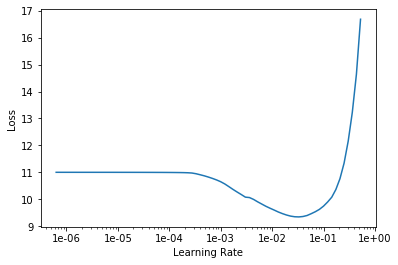

In [9]:
learn.recorder.plot()

In [10]:
lr = 3e-3

In [11]:
learn.unfreeze()
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.604265,4.557671,0.245725,40:11


In [12]:
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.584018,4.526256,0.251345,40:15
1,4.656997,4.529649,0.251449,40:14
2,4.530280,4.495327,0.253649,40:13
3,4.432180,4.451993,0.258678,40:16
4,4.427098,4.391786,0.267315,40:13
5,4.416278,4.324963,0.275175,40:13
6,4.256142,4.253808,0.284381,40:15
7,4.186808,4.191596,0.292675,40:16
8,4.108404,4.156393,0.297582,40:11
9,4.102688,4.145303,0.299001,40:12


In [14]:
learn.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.403142,4.322378,0.276298,40:09
1,4.393011,4.379038,0.269147,40:15
2,4.278040,4.289118,0.279461,40:15
3,4.162799,4.178154,0.293882,40:14
4,4.149889,4.136395,0.299280,40:18


In [15]:
learn.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.250877,4.301866,0.280094,40:25
1,4.336193,4.369737,0.271003,40:26
2,4.324943,4.276045,0.281704,40:20
3,4.182162,4.158737,0.296550,40:30
4,4.013861,4.117033,0.301939,40:19


In [7]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True, parents=True)

In [7]:
model_basename = 'awdlstm_train-imslp_lm'
learn.save(mdl_path/f'{model_basename}_wt', with_opt=False)
learn.data.vocab.save(mdl_path/f'{model_basename}_vocab.pkl')

### Finetune Language Model

In [8]:
data_target_lm = load_data(path, 'lm_target_databunch', bs=bs)

In [9]:
lm_fns = [mdl_path/f'{model_basename}_wt', mdl_path/f'{model_basename}_vocab']
learn_lm = language_model_learner(data_target_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [10]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


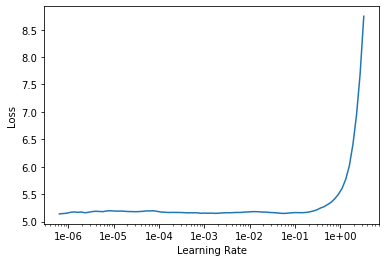

In [11]:
learn_lm.recorder.plot()

In [12]:
lr = 1e-3

In [13]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.752936,4.269238,0.277259,00:34
1,4.422865,4.195654,0.282574,00:35


In [14]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.287589,4.143975,0.287281,00:43
1,4.204573,4.092206,0.292918,00:44
2,4.119124,4.060900,0.295815,00:44
3,4.097017,4.036776,0.299028,00:44
4,3.896873,4.023338,0.300443,00:44
5,3.795566,4.016150,0.301446,00:44
6,3.727567,4.010584,0.301907,00:44
7,3.768319,4.009779,0.302065,00:45


In [11]:
ftmodel_basename = 'awdlstm_train-imslp_finetune-target_lm'
learn_lm.save(ftmodel_basename)
learn_lm.save_encoder(f'{ftmodel_basename}enc')

### Train Classifier

In [9]:
train_df = pd.read_csv(path/'train64.csv')
valid_df = pd.read_csv(path/'valid64.csv')
test_df = pd.read_csv(path/'test64.csv')

In [10]:
basicTokenizer = Tokenizer(pre_rules=[], post_rules=[])
data_clas = TextDataBunch.from_df(path, train_df, valid_df, tokenizer=basicTokenizer,
                                  vocab = data_target_lm.vocab, bs=bs, num_workers=1)

In [12]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False, drop_mult=0.5, 
                                  metrics=[accuracy, FBeta(average='macro', beta=1)])
learn_c.load_encoder(f'{ftmodel_basename}enc')
learn_c.freeze()

In [13]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


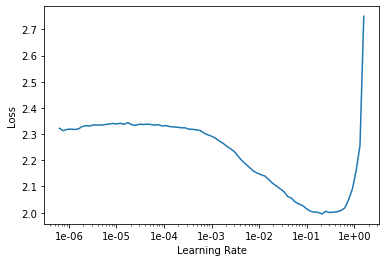

In [14]:
learn_c.recorder.plot()

In [16]:
lr = 3e-4

In [17]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.395227,1.463840,0.469444,00:58
1,1.284507,1.421558,0.484352,00:58


In [18]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.247200,1.410879,0.486667,00:59
1,1.178229,1.402540,0.484907,00:48


In [19]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.111880,1.371822,0.497037,00:34
1,1.042068,1.363523,0.498519,00:34


In [20]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.009897,1.359744,0.507037,00:46
1,0.952147,1.363482,0.505000,00:47


In [21]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.926874,1.361013,0.505185,01:00


In [23]:
learn_c.save('awdlstm_train-imslp_finetune-target_clas')

In [13]:
learn_c.load('awdlstm_train-imslp_finetune-target_clas')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (32400 items)
x: TextList
xxbos 2199023255552 8796097216512 8796093022208 1134696000913408 281474976710656 8388608 34359738368 137438953472 1099511627776 4398048608256 4398046511104 8796093546496 1099511627776 1099512676352 549755813888 2199023386624 68719542272 137438986240 16384 8192 4096 2048 137438953472 1099511627776 4398046511104 17592186306560 17592186044416 17592186109952 70368744177664 549755944960 68719476736 549755813888 8796109799424 8796093022208 4194304 281474976710656 5497558138880 274877906944 8388608 4398046511104 17592186044416 140737488355328 262144 1099511627776 4398046511104 17592186044416 1048576 8796093022208 2199023255552 549755813888 1271310319616 65536 262144 1048576 8388608 8388608 8388608 8192 32768 131072 1048576 1048576 1099512676352 549755813888,xxbos 2748779331584 524288 262144 64 16384 5497558401024 524288 262144 21990240944128 262144 5497558663168 262160 5497558147072 2748779331584 524288 262144 1677

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [14]:
data_clas_test = TextDataBunch.from_df(path, train_df, test_df, tokenizer=basicTokenizer,
                                       vocab = data_target_lm.vocab, bs=bs, num_workers=1)

In [15]:
learn_c.validate(data_clas_test.valid_dl)

[1.3262881, tensor(0.5299), tensor(0.5270)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.


In [16]:
train_fullpage_df = pd.read_csv(path/'train.fullpage.csv')
valid_fullpage_df = pd.read_csv(path/'valid.fullpage.csv')
test_fullpage_df = pd.read_csv(path/'test.fullpage.csv')

In [17]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_fullpage_df)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.5889570713043213, 0.629601240158081),
 (0.5634555275545872, 0.581931858428432))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [18]:
test_ensemble_df = pd.read_csv(path/'test.ensemble64.csv')

In [19]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learn_c, path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.6434049010276794, 0.6303681135177612),
 (0.6058298360795864, 0.5649415646098271))

### Error Analysis

In [31]:
interp = ClassificationInterpretation.from_learner(learn_c)

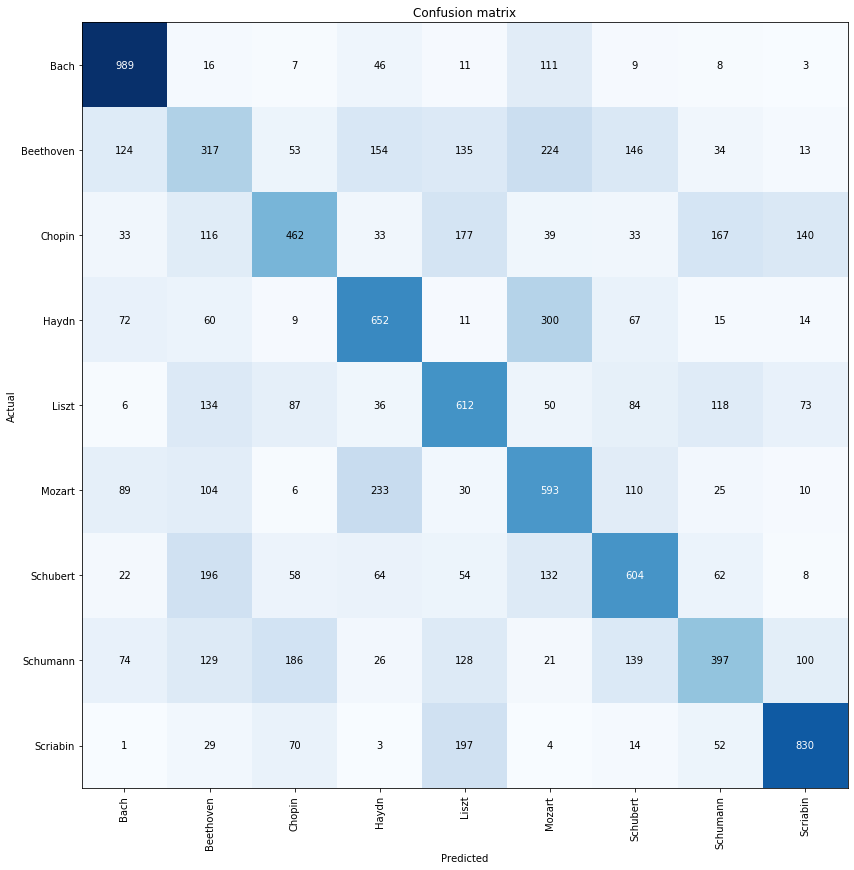

In [32]:
interp.plot_confusion_matrix(figsize=(12,12))